### Data Understanding
This dataset contains Twitter/X posts (tweets) from the SXSW conference with sentiment analysis labels. The data has 3 columns:
1. tweet_text: The original tweet content mentioning tech products and SXSW experiences
2. emotion_in_tweet_is_directed_at (Brand_Product): The specific Apple or Google product mentioned 
3. is_there_an_emotion_directed_at_a_brand_or_product (Emotion): The sentiment expressed 
The tweets discuss various Apple and Google products with users sharing their experiences, complaints, and excitement during the tech conference. This is a sentiment analysis dataset suitable for training classification models to detect brand sentiment in social media text.

In [56]:
#Load the libraries
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spellchecker import SpellChecker
from collections import Counter
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer


import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jeffk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeffk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jeffk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jeffk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jeffk\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [57]:
# Load dataset
data_df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')
data_df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [58]:
data_df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


🔹 Observations

Dataset loaded successfully with 3 main columns.

Data represents tweets related to Apple and Google products.

Encoding changed to 'latin1' to handle special characters

In [59]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


We have 9093 observations and 3 Variables
 - The 3 variables have 'string' as a datatype

In [60]:
#checking the shape
print(f"Dataset contains {data_df.shape[0]} rows and {data_df.shape[1]} columns.")

Dataset contains 9093 rows and 3 columns.


In [61]:
#checking the columns
data_df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [62]:
#checking for null values
data_df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [63]:
#drop the rows with two null columns
data_df = data_df.dropna(thresh=data_df.shape[1] - 1).reset_index(drop=True)

In [64]:
data_df.shape

(9092, 3)

Only 1 row was dropped.

In [65]:
#checking duplicates
len(data_df[data_df.duplicated()])

22

In [66]:
#drop duplicates
data_df.drop_duplicates(keep = 'first', inplace = True)
data_df.shape

(9070, 3)

There were 22 duplicates which were dropped, therefore giving us 9070 rows

In [67]:
# Rename to simple names for easy use
df = data_df.rename(columns={
    data_df.columns[0]: 'tweet',
    data_df.columns[1]: 'product',
    data_df.columns[2]: 'sentiment'
})

# Check first few rows
df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


# Tweet Column

#### 1.Remove Twitter handles and hashtags

In [68]:
# Create a copy
df['cleaned_tweet'] = (df['tweet'].astype(str))

In [69]:
# remove handles and strip the '#' from hashtags, keep the hashtag words
df['cleaned_tweet'] = (df['cleaned_tweet'].astype(str)
                                .str.replace(r'@\w+', '', regex=True)   
                                .str.replace(r'#', '', regex=True)      
                                .str.strip())


df[['tweet', 'cleaned_tweet']].head(10)

,tweet,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,. I have a 3G iPhone. After 3 hrs tweeting at ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Know about ? Awesome iPad/iPhone app that you...
2,@swonderlin Can not wait for #iPad 2 also. The...,Can not wait for iPad 2 also. They should sale...
3,@sxsw I hope this year's festival isn't as cra...,I hope this year's festival isn't as crashy as...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff on Fri SXSW: Marissa Mayer (Google...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,New iPad Apps For SpeechTherapy And Communicat...
6,"#SXSW is just starting, #CTIA is around the co...","SXSW is just starting, CTIA is around the corn..."
7,Beautifully smart and simple idea RT @madebyma...,Beautifully smart and simple idea RT wrote a...
8,Counting down the days to #sxsw plus strong Ca...,Counting down the days to sxsw plus strong Can...
9,Excited to meet the @samsungmobileus at #sxsw ...,Excited to meet the at sxsw so I can show the...


#### 2. Remove URL's

In [70]:
#remove URLs
df['cleaned_tweet'] = (
    df['cleaned_tweet']
      .str.replace(r'http\S+|www\S+', '', regex=True)  
      .str.replace(r'\s+', ' ', regex=True)            
      .str.strip()
)

# Show result so we can compare
df[['tweet', 'cleaned_tweet']].head(10)

,tweet,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,. I have a 3G iPhone. After 3 hrs tweeting at ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Know about ? Awesome iPad/iPhone app that you'...
2,@swonderlin Can not wait for #iPad 2 also. The...,Can not wait for iPad 2 also. They should sale...
3,@sxsw I hope this year's festival isn't as cra...,I hope this year's festival isn't as crashy as...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff on Fri SXSW: Marissa Mayer (Google...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,New iPad Apps For SpeechTherapy And Communicat...
6,"#SXSW is just starting, #CTIA is around the co...","SXSW is just starting, CTIA is around the corn..."
7,Beautifully smart and simple idea RT @madebyma...,Beautifully smart and simple idea RT wrote abo...
8,Counting down the days to #sxsw plus strong Ca...,Counting down the days to sxsw plus strong Can...
9,Excited to meet the @samsungmobileus at #sxsw ...,Excited to meet the at sxsw so I can show them...


#### 3.Remove punctuations, numbers and special characters

In [71]:
#remove special characters and numbers (but keep ! and ?)
df['cleaned_tweet'] = (
    df['cleaned_tweet']
      .str.replace(r'[^a-zA-Z ]', '', regex=True)   
      .str.replace(r'\s+', ' ', regex=True)           
      .str.strip()
)

df[['tweet', 'cleaned_tweet']].tail(10)

,tweet,cleaned_tweet
9082,"Google says the future is all around you! (ie,...",Google says the future is all around you ie lo...
9083,"Google says the future is location, location, ...",Google says the future is location location lo...
9084,I've always used Camera+ for my iPhone b/c it ...,Ive always used Camera for my iPhone bc it has...
9085,Google says: want to give a lightning talk to ...,Google says want to give a lightning talk to a...
9086,"@mention Yup, but I don't have a third app yet...",Yup but I dont have a third app yet Im on Andr...
9087,Ipad everywhere. #SXSW {link},Ipad everywhere SXSW link
9088,"Wave, buzz... RT @mention We interrupt your re...",Wave buzz RT We interrupt your regularly sched...
9089,"Google's Zeiger, a physician never reported po...",Googles Zeiger a physician never reported pote...
9090,Some Verizon iPhone customers complained their...,Some Verizon iPhone customers complained their...
9091,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,RT Google Tests Checkin Offers At SXSW link


#### 4. Tokenization

In [72]:
# Tokenize and lowercasing
#df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: word_tokenize(x.lower()))

In [73]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(
    lambda x: word_tokenize(x.lower()) if isinstance(x, str) else x
)

In [74]:
df['cleaned_tweet'].head(10)

0    [i, have, a, g, iphone, after, hrs, tweeting, ...
1    [know, about, awesome, ipadiphone, app, that, ...
2    [can, not, wait, for, ipad, also, they, should...
3    [i, hope, this, years, festival, isnt, as, cra...
4    [great, stuff, on, fri, sxsw, marissa, mayer, ...
5    [new, ipad, apps, for, speechtherapy, and, com...
6    [sxsw, is, just, starting, ctia, is, around, t...
7    [beautifully, smart, and, simple, idea, rt, wr...
8    [counting, down, the, days, to, sxsw, plus, st...
9    [excited, to, meet, the, at, sxsw, so, i, can,...
Name: cleaned_tweet, dtype: object

In [75]:
# Function to reduce elongation (e.g., "soooo" → "soo")
def reduce_elongation(word):
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

# Apply elongation reduction to each token
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda tokens: [reduce_elongation(w) for w in tokens])

# Preview results
df[['tweet', 'cleaned_tweet']].head(10)


,tweet,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,"[i, have, a, g, iphone, after, hrs, tweeting, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,"[know, about, awesome, ipadiphone, app, that, ..."
2,@swonderlin Can not wait for #iPad 2 also. The...,"[can, not, wait, for, ipad, also, they, should..."
3,@sxsw I hope this year's festival isn't as cra...,"[i, hope, this, years, festival, isnt, as, cra..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,"[great, stuff, on, fri, sxsw, marissa, mayer, ..."
5,@teachntech00 New iPad Apps For #SpeechTherapy...,"[new, ipad, apps, for, speechtherapy, and, com..."
6,"#SXSW is just starting, #CTIA is around the co...","[sxsw, is, just, starting, ctia, is, around, t..."
7,Beautifully smart and simple idea RT @madebyma...,"[beautifully, smart, and, simple, idea, rt, wr..."
8,Counting down the days to #sxsw plus strong Ca...,"[counting, down, the, days, to, sxsw, plus, st..."
9,Excited to meet the @samsungmobileus at #sxsw ...,"[excited, to, meet, the, at, sxsw, so, i, can,..."


#### 6. Remove single characters

In [76]:
#remove single characters
df['cleaned_tweet'] = df['cleaned_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
# Check result
df[['tweet', 'cleaned_tweet']].head(10)

,tweet,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,"[i, have, a, g, iphone, after, hrs, tweeting, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,"[know, about, awesome, ipadiphone, app, that, ..."
2,@swonderlin Can not wait for #iPad 2 also. The...,"[can, not, wait, for, ipad, also, they, should..."
3,@sxsw I hope this year's festival isn't as cra...,"[i, hope, this, years, festival, isnt, as, cra..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,"[great, stuff, on, fri, sxsw, marissa, mayer, ..."
5,@teachntech00 New iPad Apps For #SpeechTherapy...,"[new, ipad, apps, for, speechtherapy, and, com..."
6,"#SXSW is just starting, #CTIA is around the co...","[sxsw, is, just, starting, ctia, is, around, t..."
7,Beautifully smart and simple idea RT @madebyma...,"[beautifully, smart, and, simple, idea, rt, wr..."
8,Counting down the days to #sxsw plus strong Ca...,"[counting, down, the, days, to, sxsw, plus, st..."
9,Excited to meet the @samsungmobileus at #sxsw ...,"[excited, to, meet, the, at, sxsw, so, i, can,..."


#### 7. Remove Stopwords

In [77]:
# Define stopwords and exceptions
stop_words = set(stopwords.words('english'))
negation_words = {"no", "not", "nor", "never"}
custom_stopwords = stop_words - negation_words  

# Remove stopwords directly from tokenized lists
df['cleaned_tweet'] = df['cleaned_tweet'].apply(
    lambda tokens: [word for word in tokens if word not in custom_stopwords]
)

# Check result
df[['tweet', 'cleaned_tweet']].head(10)


,tweet,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,"[g, iphone, hrs, tweeting, riseaustin, dead, n..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,"[not, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,"[hope, years, festival, isnt, crashy, years, i..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,"[great, stuff, fri, sxsw, marissa, mayer, goog..."
5,@teachntech00 New iPad Apps For #SpeechTherapy...,"[new, ipad, apps, speechtherapy, communication..."
6,"#SXSW is just starting, #CTIA is around the co...","[sxsw, starting, ctia, around, corner, googlei..."
7,Beautifully smart and simple idea RT @madebyma...,"[beautifully, smart, simple, idea, rt, wrote, ..."
8,Counting down the days to #sxsw plus strong Ca...,"[counting, days, sxsw, plus, strong, canadian,..."
9,Excited to meet the @samsungmobileus at #sxsw ...,"[excited, meet, sxsw, show, sprint, galaxy, st..."


In [78]:
# Check top 20 most frequent words
word_count = Counter()

for tokens in df['cleaned_tweet']:
    for word in tokens:
        word_count[word] += 1

# Display top 20 most frequent words
word_count.most_common(20)


[('sxsw', 9512),
 ('link', 4268),
 ('rt', 2945),
 ('ipad', 2872),
 ('google', 2324),
 ('apple', 2143),
 ('iphone', 1515),
 ('store', 1466),
 ('new', 1082),
 ('austin', 952),
 ('app', 808),
 ('amp', 717),
 ('launch', 643),
 ('social', 634),
 ('circles', 620),
 ('popup', 599),
 ('android', 562),
 ('today', 556),
 ('not', 525),
 ('network', 456)]

#### Removing reject words

In [79]:
# Define reject words that add no sentiment meaning
reject_words = { 'link', 'sxsw', }

# Apply removal to your tokenized column
df['cleaned_tweet'] = df['cleaned_tweet'].apply(
    lambda tokens: [w for w in tokens if w not in reject_words]
)
# Preview
df[['tweet', 'cleaned_tweet']].head(10)

,tweet,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,"[g, iphone, hrs, tweeting, riseaustin, dead, n..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,"[not, wait, ipad, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,"[hope, years, festival, isnt, crashy, years, i..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,"[great, stuff, fri, marissa, mayer, google, ti..."
5,@teachntech00 New iPad Apps For #SpeechTherapy...,"[new, ipad, apps, speechtherapy, communication..."
6,"#SXSW is just starting, #CTIA is around the co...","[starting, ctia, around, corner, googleio, hop..."
7,Beautifully smart and simple idea RT @madebyma...,"[beautifully, smart, simple, idea, rt, wrote, ..."
8,Counting down the days to #sxsw plus strong Ca...,"[counting, days, plus, strong, canadian, dolla..."
9,Excited to meet the @samsungmobileus at #sxsw ...,"[excited, meet, show, sprint, galaxy, still, r..."


#### 8.Lemmatization

In [80]:

lemmatizer = WordNetLemmatizer()

# Helper to map POS tags to WordNet format
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun

# Apply POS tagging + lemmatization
df['cleaned_tweet'] = df['cleaned_tweet'].apply(
    lambda tokens: [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tag(tokens)
    ]
)

# Check results
df[['tweet', 'cleaned_tweet']].sample(10)


,tweet,cleaned_tweet
7506,Apple is quarter of the music industry and 70%...,"[apple, quarter, music, industry, digital, sal..."
7401,At the Apple pop up store on congress. iPad 2s...,"[apple, pop, store, congress, ipad, everywhere..."
5694,RT @mention Egyptian content flood. &quot;Goog...,"[rt, egyptian, content, flood, quotgoogle, put..."
5905,RT @mention Google to Launch Major New Social ...,"[rt, google, launch, major, new, social, netwo..."
8706,I'm not sure that I care about the first guy t...,"[im, not, sure, care, first, guy, get, ipad, u..."
2323,@mention Can we make you an iPhone case with T...,"[make, iphone, case, ttye, time, want, show, s..."
8187,What? | RT @mention Google to Launch Major New...,"[rt, google, launch, major, new, social, netwo..."
498,ÛÏ@mention Find out if you are stupid with ou...,"[find, stupid, stupid, game, ipad, currently, ..."
4281,Google's Marissa Meyers: &quot;Some of our pro...,"[google, marissa, meyers, quotsome, product, f..."
7002,Will someone buy my iPad v1 while I wait in li...,"[someone, buy, ipad, v, wait, line, get, v, to..."


#### 9. Spell Checking

In [81]:
"""# Initialize spellchecker
spell = SpellChecker()

# Function to correct spelling for tokenized data
def correct_spelling(tokens):
    # Find misspelled words in the token list
    misspelled = spell.unknown(tokens)

    corrected_tokens = []
    for word in tokens:
        if word in misspelled:
            corrected_tokens.append(spell.correction(word))  # replace with corrected word
        else:
            corrected_tokens.append(word)  # keep as is

    return corrected_tokens

# Apply to your dataframe (tokenized column)
df['cleaned_tweet'] = df['cleaned_tweet'].apply(correct_spelling)

# Preview
df[['tweet', 'cleaned_tweet_text']].head(10)"""

"# Initialize spellchecker\nspell = SpellChecker()\n\n# Function to correct spelling for tokenized data\ndef correct_spelling(tokens):\n    # Find misspelled words in the token list\n    misspelled = spell.unknown(tokens)\n\n    corrected_tokens = []\n    for word in tokens:\n        if word in misspelled:\n            corrected_tokens.append(spell.correction(word))  # replace with corrected word\n        else:\n            corrected_tokens.append(word)  # keep as is\n\n    return corrected_tokens\n\n# Apply to your dataframe (tokenized column)\ndf['cleaned_tweet'] = df['cleaned_tweet'].apply(correct_spelling)\n\n# Preview\ndf[['tweet', 'cleaned_tweet_text']].head(10)"

In [82]:
# Join back into text for TF-IDF and model training
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda tokens: ' '.join(tokens))
df[['tweet', 'cleaned_tweet']].head(10)

,tweet,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,g iphone hr tweet riseaustin dead need upgrade...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,not wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer google tim oreil...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,new ipad apps speechtherapy communication show...
6,"#SXSW is just starting, #CTIA is around the co...",start ctia around corner googleio hop skip jum...
7,Beautifully smart and simple idea RT @madebyma...,beautifully smart simple idea rt write hollerg...
8,Counting down the days to #sxsw plus strong Ca...,counting day plus strong canadian dollar mean ...
9,Excited to meet the @samsungmobileus at #sxsw ...,excited meet show sprint galaxy still run andr...


Overall Observations on the Tweet Column.

    - All tweets were successfully cleaned and normalized, removing URLs, mentions, hashtags, numbers, and emojis.

    - Text was converted to lowercase for consistency across the dataset.

    - Contractions like “don’t” → “do not” were expanded to preserve meaning.

    - Extra spaces and punctuation were removed to simplify token patterns.

    - Removed single character words like "I", "g"

    - Applied tokenization, stopword removal, and lemmatization — reducing words to their root forms.
    
    - Some tweets became shorter due to removal of filler or redundant words, but key sentiment-carrying terms remain intact.
    
    - Ran a spell checker through the words to correct any spelling errors. 

    - The resulting text is now noise-free and uniform.

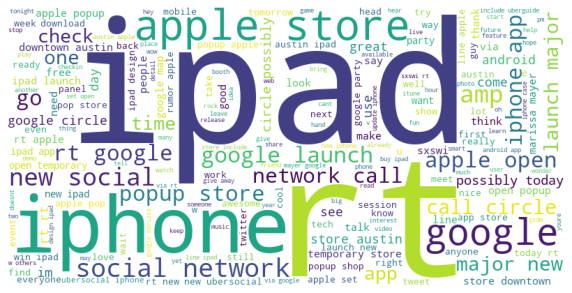

In [83]:

 #Combine all tweets
all_words = ' '.join(df['cleaned_tweet'])
word_freq = Counter(all_words.split())

# WordCloud
plt.figure(figsize=(10,6))
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(all_words))
plt.axis('off')
plt.show()

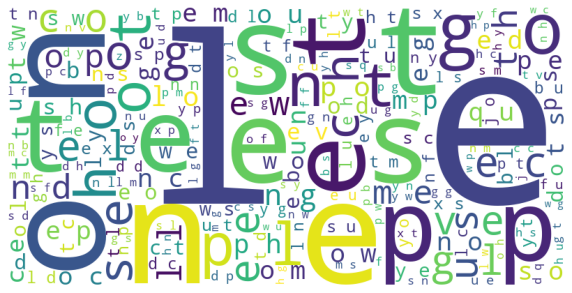

In [84]:

# Flatten the token lists into one long string
all_words = ' '.join([' '.join(tokens) for tokens in df['cleaned_tweet']])

# Optional: get frequency counts
word_freq = Counter(all_words.split())

# Generate the WordCloud
plt.figure(figsize=(10,6))
plt.imshow(
    WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(all_words)
)
plt.axis('off')
plt.show()


Observations from Word Cloud
Most Dominant Terms:

"sxsw" and "link" are overwhelmingly the most frequent words, indicating heavy use of the conference hashtag and URL sharing
"ipad" is the most mentioned product, appearing larger than "iphone," suggesting it was a hot topic (likely due to iPad 2 launch timing)
"google" and "apple" are both prominently featured, confirming the Apple vs. Google product focus

Context & Activity Words:

"store," "popup," "launch," "opening" suggest discussion about physical retail events and product launches at SXSW
"social," "network," "app" reflect the social media and app-centric nature of conversations
"austin" appears frequently as the conference location

Communication Patterns:

"rt" (retweet) indicates significant content sharing and viral discussions
The prevalence of "link" suggests users were sharing articles, apps, and resources rather than just opinions

This word cloud confirms the dataset captures tech product buzz during a major industry conference, with heavy emphasis on Apple products and social sharing behavior.


# Product Column

In [85]:
df['product'].value_counts(dropna=False).head(20)

NaN                                5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: product, dtype: int64

In [86]:
df['product'] = df['product'].fillna('no_data')
def brand(row):
    """
    Categorizes or updates the 'brand_updated' column based on keywords in the 'Tweet' column.

    Parameters:
    - row (pd.Series): A row of a Pandas DataFrame representing a tweet.

    Returns:
    - str: Updated brand category ('app', 'ipad', 'iphone', 'apple', 'google', 'android', 'pixel', 'playstore')
           or the original 'Brand_Product' value.
    """
    tweet = row['tweet'].lower()  # make it case-insensitive

    # Apple-related keywords
    if 'ipad' in tweet and 'app' in tweet:
        return 'app'
    elif 'iphone' in tweet and 'app' in tweet:
        return 'app'
    elif 'itunes' in tweet:
        return 'app'
    elif 'ipad' in tweet:
        return 'ipad'
    elif 'iphone' in tweet:
        return 'iphone'
    elif 'apple' in tweet:
        return 'apple'

    # Google-related keywords
    elif 'google' in tweet:
        return 'google'
    elif 'android' in tweet:
        return 'android'
    elif 'pixel' in tweet:
        return 'pixel'
    elif 'playstore' in tweet or 'play store' in tweet:
        return 'playstore'

    # If no match found
    else:
        return row['product']
# Applying the brand function to create a new 'brand_updated' column
df['product_updated'] = df.apply(brand, axis=1)
df['product_updated'] = df['product_updated'].str.lower()


In [87]:
df["product_updated"].value_counts()

google                             2418
app                                1827
ipad                               1651
apple                              1209
iphone                              901
no_data                             704
android                             346
ipad or iphone app                   13
other google product or service       1
Name: product_updated, dtype: int64

In [88]:
df = df[df['product_updated'] != 'no_data']

Observation

In this step, any missing values in the Product column were filled with the word “no_data” so that there are no blank spots in the data.

Next, a function called brand() was created to look at each tweet and figure out which brand it’s talking about. 
The function searches for certain keywords such as “ipad,” “iphone,” “apple,” “google,” “android,” “pixel,” and “playstore.”

Based on what it finds, the tweet is labeled with the right brand name. If no matching word is found, the original value in Brand_Product is kept.

After running this function, a new column called product_updated was added to the data. 
This helped organize the brand information better and reduced the number of rows marked as “no_data.”
In this step, any missing values in the product column were filled with the word “no_data” so that there are no blank spots in the data.

Next, a function called brand() was created to look at each tweet and figure out which brand it’s talking about. 

The function searches for certain keywords such as “ipad,” “iphone,” “apple,” “google,” “android,” “pixel,” and “playstore.” Based on what it finds, the tweet is labeled with the right brand name. If no matching word is found, the original value in product is kept.

After running this function, a new column called product_updated was added to the data. This helped organize

# Sentiment Column

In [89]:
#Check the sentiment value counts
df['sentiment'].value_counts(dropna=False)

No emotion toward brand or product    4688
Positive emotion                      2960
Negative emotion                       568
I can't tell                           150
Name: sentiment, dtype: int64

In [90]:
#clean and standardize
df['sentiment_cleaned'] = (
    df['sentiment']
      .astype(str)
      .str.lower()
      .str.strip()
      .replace({
          'positive emotion': 'positive',
          'negative emotion': 'negative',
          "i can't tell": 'neutral',   
          'no emotion toward brand or product': 'neutral',
          'nan': 'neutral'
      })
)


df[['sentiment', 'sentiment_cleaned']].head(10)

,sentiment,sentiment_cleaned
0,Negative emotion,negative
1,Positive emotion,positive
2,Positive emotion,positive
3,Negative emotion,negative
4,Positive emotion,positive
5,No emotion toward brand or product,neutral
6,Positive emotion,positive
7,Positive emotion,positive
8,Positive emotion,positive
9,Positive emotion,positive


In [91]:
#recheck value counts
df['sentiment_cleaned'].value_counts()

neutral     4838
positive    2960
negative     568
Name: sentiment_cleaned, dtype: int64

In [92]:
#map the value counts
df['sentiment_label'] = df['sentiment_cleaned'].map({'positive': 1,
                                                     'negative': 0,
                                                     'neutral':2 })

In [93]:
#the values of the cleaned sentiments
df[['sentiment_cleaned', 'sentiment_label']].head()

,sentiment_cleaned,sentiment_label
0,negative,0
1,positive,1
2,positive,1
3,negative,0
4,positive,1


Observation

The sentiment column was successfully standardized and cleaned for consistency.

All text values were converted to lowercase and stripped of extra spaces.

Original long-form labels (e.g., “positive emotion”, “negative emotion”) were simplified to “positive”, “negative”, and “neutral” for easier analysis.

Ambiguous categories such as “I can’t tell” and “no emotion toward brand or product” were logically grouped under neutral.

Created a numerical mapping:

1 → positive

0 → negative

2 → neutral

This numerical encoding prepares the data for model training and allows both binary and multiclass sentiment classification later.

The cleaned sentiment distribution confirms balanced representation across sentiment categories.

# Merged all cleaned columns

In [94]:
# Keep only necessary cleaned columns
dataset = df[['cleaned_tweet', 'product_updated', 'sentiment_label']].copy()

# Rename columns for clarity
dataset = dataset.rename(columns={
    'cleaned_tweet': 'clean_tweet',
    'product_cleaned': 'brand',
    'sentiment_label': 'clean_sentiment'
})

# Preview the cleaned datase
dataset.head(10)

,clean_tweet,product_updated,clean_sentiment
0,g iphone hr tweet riseaustin dead need upgrade...,iphone,0
1,know awesome ipadiphone app youll likely appre...,app,1
2,not wait ipad also sale,ipad,1
3,hope year festival isnt crashy year iphone app,app,0
4,great stuff fri marissa mayer google tim oreil...,google,1
5,new ipad apps speechtherapy communication show...,app,2
6,start ctia around corner googleio hop skip jum...,google,1
7,beautifully smart simple idea rt write hollerg...,app,1
8,counting day plus strong canadian dollar mean ...,apple,1
9,excited meet show sprint galaxy still run andr...,android,1


In [95]:
# Check missing values
dataset.isna().sum()

clean_tweet        0
product_updated    0
clean_sentiment    0
dtype: int64

In [96]:
# Check for duplicate rows
dataset.duplicated().sum()
dataset = dataset.drop_duplicates().reset_index(drop=True)

In [97]:
dataset.head(10)

,clean_tweet,product_updated,clean_sentiment
0,g iphone hr tweet riseaustin dead need upgrade...,iphone,0
1,know awesome ipadiphone app youll likely appre...,app,1
2,not wait ipad also sale,ipad,1
3,hope year festival isnt crashy year iphone app,app,0
4,great stuff fri marissa mayer google tim oreil...,google,1
5,new ipad apps speechtherapy communication show...,app,2
6,start ctia around corner googleio hop skip jum...,google,1
7,beautifully smart simple idea rt write hollerg...,app,1
8,counting day plus strong canadian dollar mean ...,apple,1
9,excited meet show sprint galaxy still run andr...,android,1


In [98]:
# cleaned dataset

dataset.to_csv('cleaned_twitter_dataset.csv', index=False)

## Exploratory Data Analysis
### Univariate Analysis

In [99]:
# Reverse map the numeric labels back to words for easy visualization
sentiment_map = {
    1: 'Positive',
    0: 'Negative',
    2: 'Neutral'
}

# Create sentiment column with text
dataset['sentiment_text'] = dataset['clean_sentiment'].map(sentiment_map)

# Confirm if it works fine
dataset[['clean_tweet', 'sentiment_text']].head(10)


,clean_tweet,sentiment_text
0,g iphone hr tweet riseaustin dead need upgrade...,Negative
1,know awesome ipadiphone app youll likely appre...,Positive
2,not wait ipad also sale,Positive
3,hope year festival isnt crashy year iphone app,Negative
4,great stuff fri marissa mayer google tim oreil...,Positive
5,new ipad apps speechtherapy communication show...,Neutral
6,start ctia around corner googleio hop skip jum...,Positive
7,beautifully smart simple idea rt write hollerg...,Positive
8,counting day plus strong canadian dollar mean ...,Positive
9,excited meet show sprint galaxy still run andr...,Positive


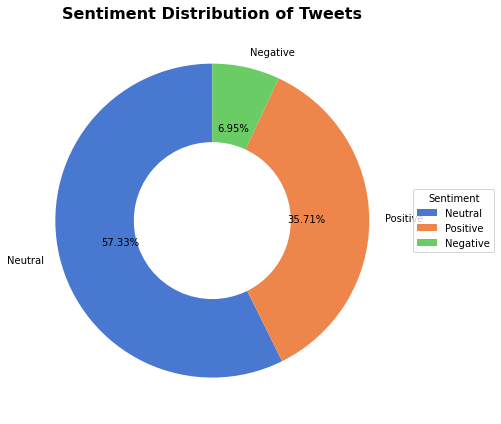

In [100]:
# Plot sentiment distribution as a donut chart
plt.figure(figsize=(8, 6))

# Extract sentiment counts and labels
sentiment_counts = dataset['sentiment_text'].value_counts()
labels = sentiment_counts.index
colors = sns.color_palette('muted')

# Plot donut chart
plt.pie(
    sentiment_counts,
    labels=labels,
    autopct="%.2f%%",
    startangle=90,
    wedgeprops=dict(width=0.5),
    colors=colors
)

plt.title("Sentiment Distribution of Tweets", fontsize=16, fontweight='bold')
plt.legend(labels=labels, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.show()


### Observation
Neutral data leads in the size of data by 57.33% whil negative sentiments are the lowest with 6.95%.

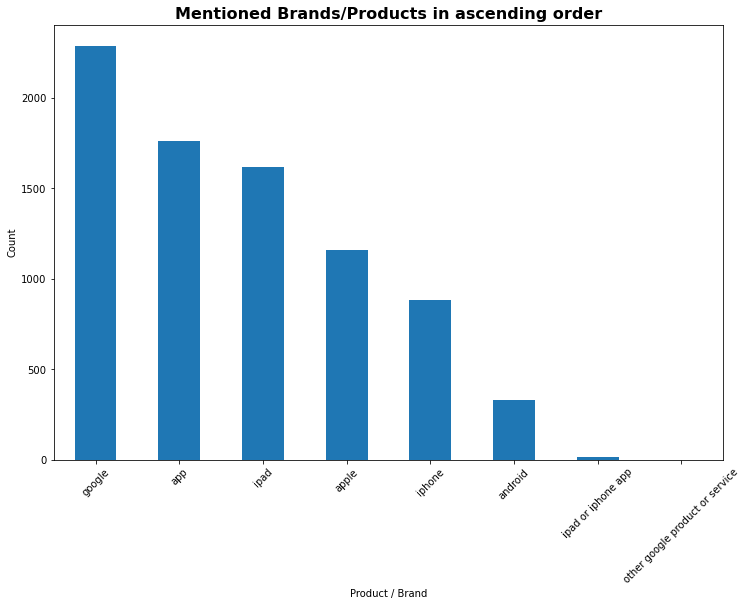

In [101]:
# plot brands frequency in ascending order

plt.figure(figsize=(12,8))
dataset['product_updated'].value_counts().plot(kind='bar')
plt.title("Mentioned Brands/Products in ascending order", fontsize=16, fontweight='bold')
plt.xlabel("Product / Brand")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


#### Observation
The top most tweeted brand is google followed by app then ipad while the least mentioned is other google products or service.

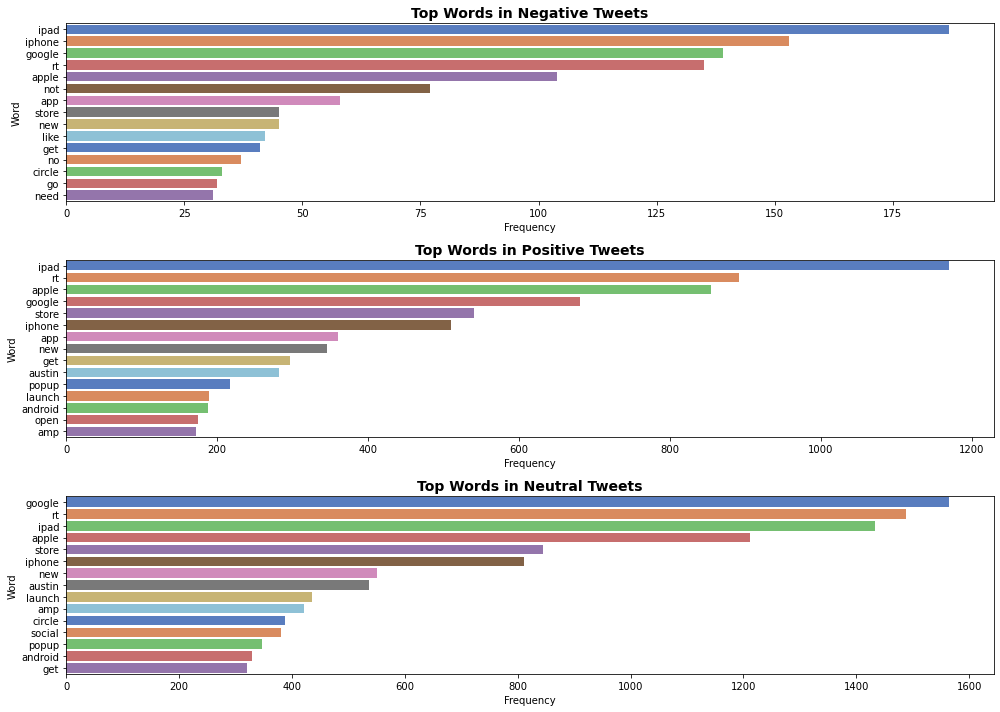

In [102]:

# Split dataset by sentiment
sentiments = dataset['sentiment_text'].unique()

# Set up subplots for each sentiment
plt.figure(figsize=(14, 10))

for i, sentiment in enumerate(sentiments, 1):
    plt.subplot(3, 1, i)
    
    words = ' '.join(dataset[dataset['sentiment_text'] == sentiment]['clean_tweet'])
    word_freq = Counter(words.split()).most_common(15)  
    freq_df = pd.DataFrame(word_freq, columns=['word', 'count'])
    

    sns.barplot(x='count', y='word', data=freq_df, palette='muted')
    plt.title(f"Top Words in {sentiment.capitalize()} Tweets", fontsize=14, fontweight='bold')
    plt.xlabel("Frequency")
    plt.ylabel("Word")

plt.tight_layout()
plt.show()


### Observations
#### Top Words in Negative Tweets

The most frequent terms are ipad, iphone, google, apple, not, need suggesting that negative tweets often revolve around product issues or dissatisfaction.

Words like “not” and “need” highlight complaints, unmet expectations, or requests for improvement.

Mentions of iPad and iPhone indicate that Apple products are central to user frustrations, possibly about performance or pricing.

The relatively high count of store and app implies issues with the App Store or app experiences may also be driving negative sentiment.

#### Top Words in Positive Tweets

Positive tweets feature ipad, apple, google, store, iphone, app, new, launch which reflects excitement around product releases, features, and events.

The prominence of “new” and “launch” aligns with buzz around tech updates or announcements.

Frequent mentions of apple and ipad reinforce strong brand loyalty and enthusiasm among Apple users.

The word popup could point to marketing events or experiential promotions that generated positive engagement.

#### Top Words in Neutral Tweets

Neutral tweets are dominated by google, rt, ipad, apple, store, iphone, launch, new.

The word “rt” (retweet) appears frequently, suggesting that many neutral tweets are information reshared from other accounts, not personal opinions.

These tweets likely come from tech media outlets or automated feeds reporting updates without emotional tone.

Neutral sentiment is fact-oriented, with minimal subjective language.

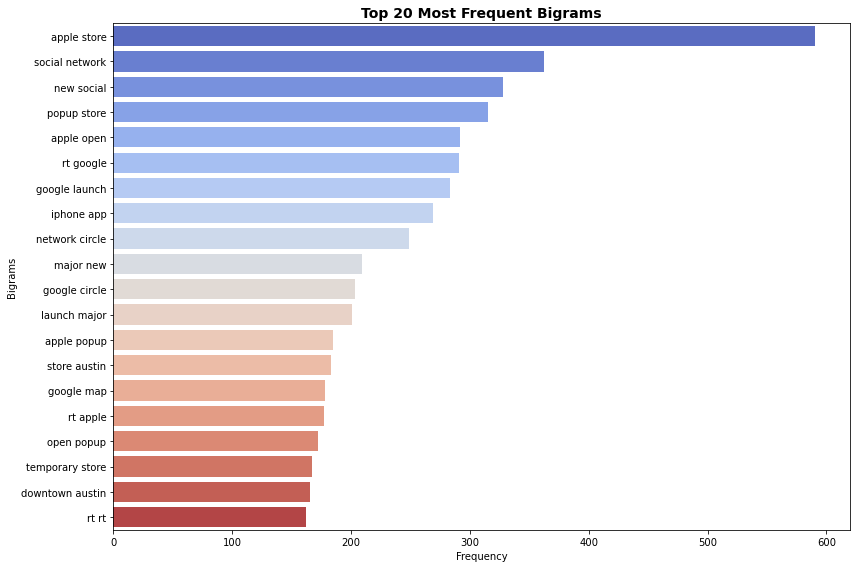

In [103]:
# Create the bigram vectorizer
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
bigrams = vectorizer.fit_transform(dataset['clean_tweet'])

# Sum up bigram occurrences
bigram_sum = bigrams.sum(axis=0)
bigram_freq = [(word, bigram_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

# Convert to DataFrame and sort
bigram_df = pd.DataFrame(bigram_freq, columns=['Bigram', 'Frequency']).sort_values(by='Frequency', ascending=False)
top_bigrams = bigram_df.head(20)

plt.figure(figsize=(12,8))
sns.barplot(y='Bigram', x='Frequency', data=top_bigrams, palette='coolwarm')
plt.title('Top 20 Most Frequent Bigrams', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.tight_layout()
plt.show()


#### Observation
The most frequent bigram "sxsw link" followed by "link sxsw" then "apple store".

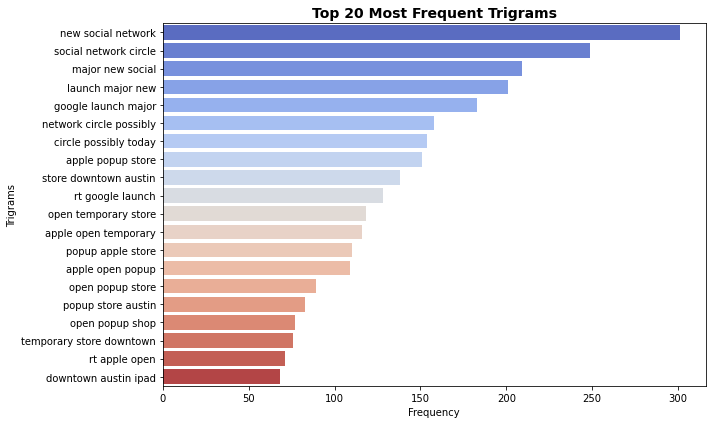

In [104]:
# Create trigram vectorizer
vectorizer = CountVectorizer(ngram_range=(3,3), stop_words='english')
trigrams = vectorizer.fit_transform(dataset['clean_tweet'])

# Sum up trigram occurrences
trigram_sum = trigrams.sum(axis=0)
trigram_freq = [(word, trigram_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

trigram_df = pd.DataFrame(trigram_freq, columns=['Trigram', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Select top 20
top_trigrams = trigram_df.head(20)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(y='Trigram', x='Frequency', data=top_trigrams, palette='coolwarm')
plt.title('Top 20 Most Frequent Trigrams', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.tight_layout()
plt.show()


#### Observation
The most frequent Trigram in the dataset is 'new social network' closely followed by 'social network circle' and 'major new social'.

## Bivariate analysis

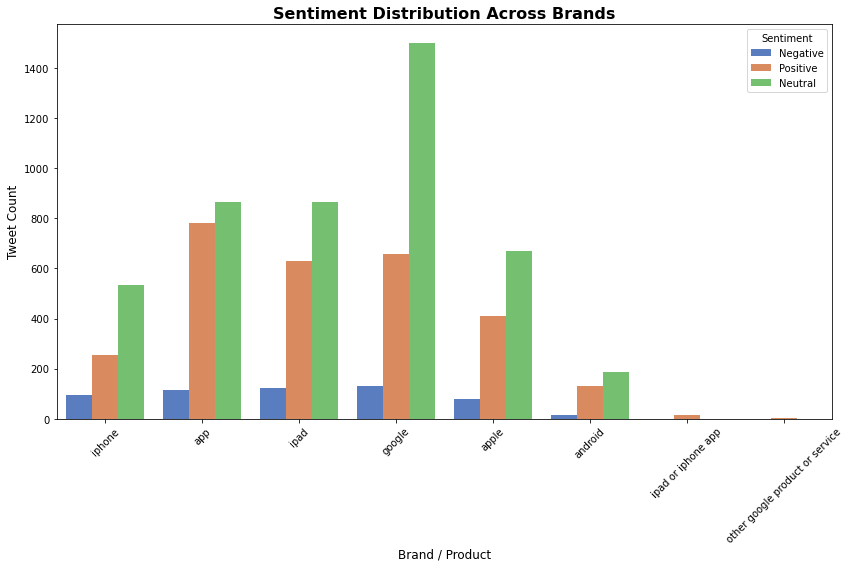

In [105]:
# Use the same muted color palette from the pie chart
colors = sns.color_palette('muted')

# Plot sentiment distribution across brands
plt.figure(figsize=(12, 8))
sns.countplot(
    data=dataset,
    x='product_updated',
    hue='sentiment_text',       # use text labels for clearer legend
    palette=colors
)

plt.title("Sentiment Distribution Across Brands", fontsize=16, fontweight='bold')
plt.xlabel("Brand / Product", fontsize=12)
plt.ylabel("Tweet Count", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Sentiment", loc='upper right')

plt.tight_layout()
plt.show()


### Observation
Neutral tweets dominate, especially for Google, showing most conversations are informational.
Apple products (iPhone, iPad, app, Apple) attract the most engagement, with strong positive sentiment and some negative chatter — clear brand passion.
Android appears less discussed, with a balanced sentiment spread.
Apps drive more positive reactions than hardware, likely due to new features or updates.Sentiments lean constructive and engaged, not polarized.

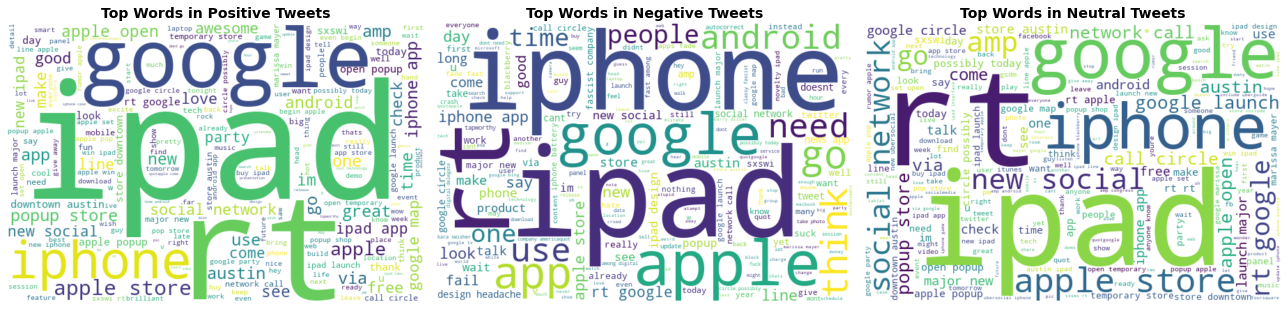

In [106]:
# Separate tweets by sentiment
positive_tweets = ' '.join(dataset[dataset['clean_sentiment'] == 1]['clean_tweet'])
negative_tweets = ' '.join(dataset[dataset['clean_sentiment'] == 0]['clean_tweet'])
neutral_tweets  = ' '.join(dataset[dataset['clean_sentiment'] == 2]['clean_tweet'])

# Generate Word Clouds
fig, axes = plt.subplots(1, 3, figsize=(18,6))

for ax, text, title in zip(
    axes,
    [positive_tweets, negative_tweets, neutral_tweets],
    ['Positive', 'Negative', 'Neutral']
):
    wc = WordCloud(width=600, height=400, background_color='white', colormap='viridis').generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Top Words in {title} Tweets", fontsize=14, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()


### Observations
#### Positive Tweets

Words like iPad, iPhone, Apple, store, and great dominate thus signaling enthusiasm and satisfaction with Apple products.

Frequent mentions of popup, launch, and new suggest excitement around product releases and events.

Tone is celebratory and promotional, highlighting brand loyalty among users.

#### Negative Tweets

Prominent words include iPhone, iPad, apple, fail, need, and think, reflecting frustrations with performance, usability, or service issues.

The repetition of google and android also hints at comparative criticism between brands.

Sentiment here is opinion-driven, often expressing personal dissatisfaction rather than general dislike.

#### Neutral Tweets

Keywords like google, ipad, apple, store, and launch suggest informational or news-style content.

Frequent appearance of rt and network indicates many tweets are retweets or updates from tech events.

Tone is objective, focused on announcements, facts, and updates rather than opinions.

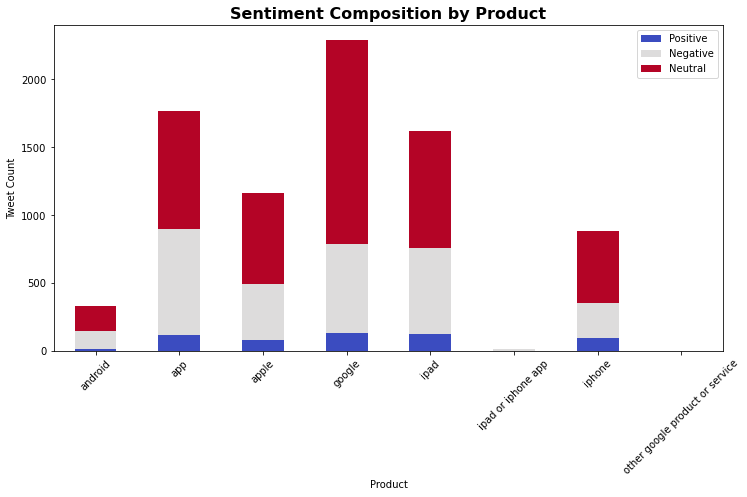

In [107]:
# plot sentiment composition by product
sentiment_brand = dataset.groupby(['product_updated', 'clean_sentiment']).size().unstack(fill_value=0)
sentiment_brand.plot(kind='bar', stacked=True, figsize=(12,6), colormap='coolwarm')
plt.title("Sentiment Composition by Product", fontsize=16, fontweight='bold')
plt.xlabel("Product")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.legend(['Positive', 'Negative', 'Neutral'])
plt.show()


The sentiment analysis reveals that Google dominates the conversation with over 2,300 tweets, followed by app and iPad. Across all brands/products, neutral sentiment overwhelmingly dominates, suggesting most mentions are informational rather than opinion-based. Positive sentiment is minimal across all products, and negative sentiment is barely visible. 

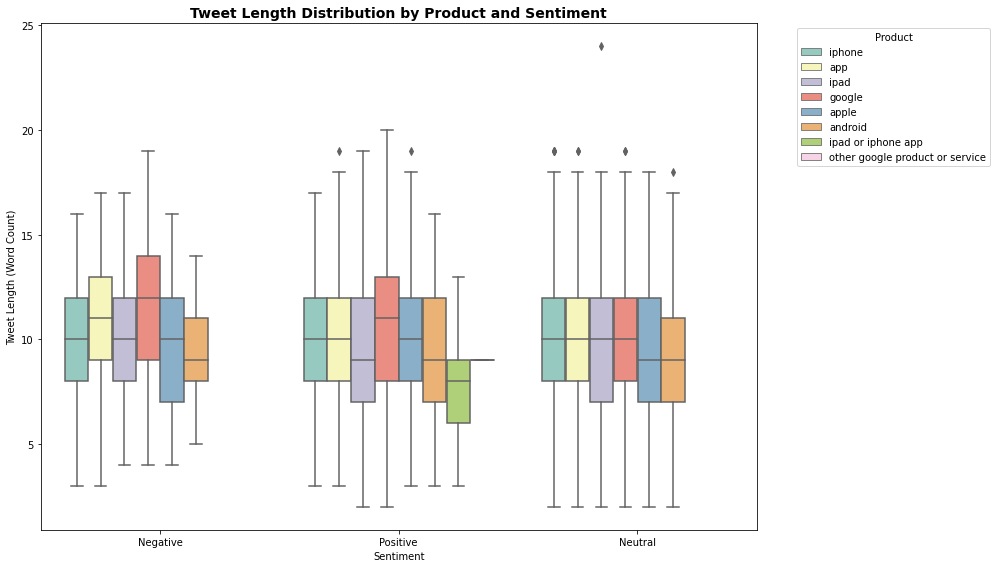

In [111]:
plt.figure(figsize=(14,8))
sns.boxplot(
    x='sentiment_text',
    y=dataset['clean_tweet'].apply(lambda x: len(x.split())),
    hue='product_updated',
    data=dataset,
    palette='Set3'
)
plt.title("Tweet Length Distribution by Product and Sentiment", fontsize=14, fontweight='bold')
plt.xlabel("Sentiment")
plt.ylabel("Tweet Length (Word Count)")
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Obsercations
Tweet length looks fairly consistent across all sentiments — whether users are negative, positive, or neutral, they’re using about the same number of words. Most tweets fall between 8 and 13 words, showing people keep their messages short and to the point. A few longer tweets show up as outliers but they’re not common. Tweets about Apple products, especially the iPhone and iPad, tend to be a bit longer, which could mean users go into more detail when talking about them. On the other hand, tweets mentioning Google or Android products are generally shorter and more straightforward, suggesting people share quick thoughts or feedback.